In [1]:
import numpy as np
from astropy import constants as C
from astropy import units
from matplotlib_import import *

In [2]:
GeV_mass = units.GeV/C.c**2

N_A = C.N_A * units.mol / units.g

rho = (0.3 * GeV_mass/units.cm**3).decompose()
v_0 = 220 * units.km/units.s
v_avg = (2/np.sqrt(np.pi)) * v_0

M = 500 *units.kg
T = 1 * units.yr
A = 131.293  # xenon
m_N = A * units.u
E_Rm = 3 * units.keV

In [3]:
mxs = np.logspace(np.log10(6), 3, 1001) * GeV_mass
sigmas = np.logspace(-40, -44, 1001) * units.cm**2

In [4]:
def mu(mx):
    return mx*C.m_p / (mx + C.m_p)

def r(mx):
    return 4 * mx*m_N / (mx+m_N)**2

def E_0(mx):
    return 0.5*mx*v_0**2

def exp_factor(mx, E):
    return np.exp(- E / (r(mx) * E_0(mx)))

def sigma(mx, R):
    return ((R * C.m_p**2) / (N_A * rho * v_avg * A)) * (mx / mu(mx)**2) / exp_factor(mx, E_Rm)

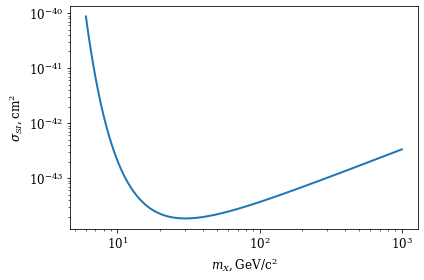

In [5]:
plt.loglog(mxs*C.c**2, sigma(mxs, 3 / units.yr / M).to(units.cm**2))
plt.xlabel('$m_X, \mathrm{GeV}/\mathrm{c}^2$')
plt.ylabel(r'$\sigma_{SI}, \mathrm{cm}^2$')
plt.tight_layout()

In [6]:
def R_0(mx, sigma):
    return (N_A * rho * A * v_avg / C.m_p ** 2) * (mu(mx) ** 2 / mx) * sigma

def R_model(E_bounds, mx, sigma):
    return R_0(mx, sigma) * (exp_factor(mx, E_bounds[0]) - exp_factor(mx, E_bounds[1])) * M * T

def chi2(E_bounds, R, mx, sigma):
    mx_nou, sigma_nou = np.broadcast_arrays(mx, sigma)
    mx = mx_nou*mx.unit
    sigma = sigma_nou*sigma.unit

    E_bounds = E_bounds.reshape(list(E_bounds.shape) + [1]*len(mx.shape))
    R = R.reshape(list(R.shape) + [1]*len(mx.shape))

    mu = R_model(E_bounds , mx[None, ...], sigma[None, ...])

    return ((R - mu)**2 / mu).sum(axis=0)

In [7]:
E_bounds = np.array(((3, 10), (10, 20))) * units.keV
R = np.array((10, 5))

c2 = chi2(E_bounds, R, mxs[None, :], sigmas[:, None]).to('')
sigma0i, mx0i = np.unravel_index(np.argmin(c2), c2.shape)
mx0, sigma0 = mxs[mx0i], sigmas[sigma0i]

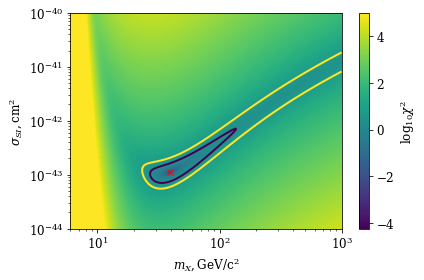

In [8]:
pcm = plt.pcolormesh(mxs*C.c**2, sigmas, np.log10(c2), vmax=5)
con = plt.contour(mxs*C.c**2, sigmas, c2, (2.28, 6))
plt.loglog(mx0*C.c**2, sigma0, 'rx')

cax = plt.colorbar(pcm)
cax.set_label(r'$\log_{10}\chi^2$')
plt.xlabel('$m_X, \mathrm{GeV}/\mathrm{c}^2$')
plt.ylabel(r'$\sigma_{SI}, \mathrm{cm}^2$')
plt.tight_layout()